# EhV Quality control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels
from ehv.masking import plot_scip_segmentation

In [4]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr
import flowutils
from pandas.api.types import CategoricalDtype

## SCIP computed features

## Load processed frame

In [45]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/features.parquet").to_pandas()

In [13]:
df = pq.read_table("/srv/scratch/maximl/data/ehv/results/scip/202202071958/features.parquet").to_pandas()

## No bounding box

In [46]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(131783, 1296)

In [47]:
df.filter(regex="feat").shape

(131783, 1277)

## Number of identified regions per channel 

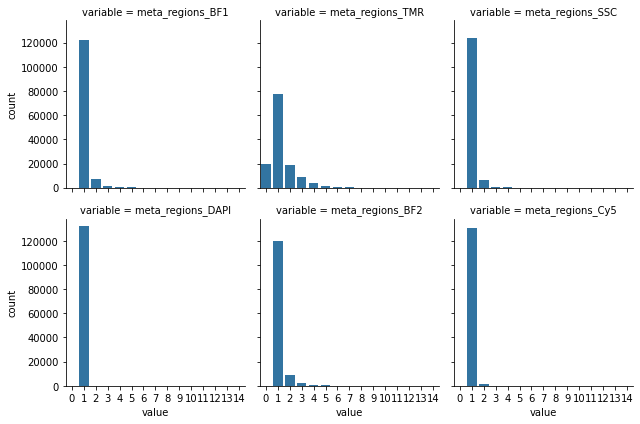

In [48]:
tmp = pandas.melt(df.reset_index(), value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype(int).astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable", col_wrap=3)
grid.map_dataframe(seaborn.countplot, x="value")
plt.savefig("number_of_regions.png")

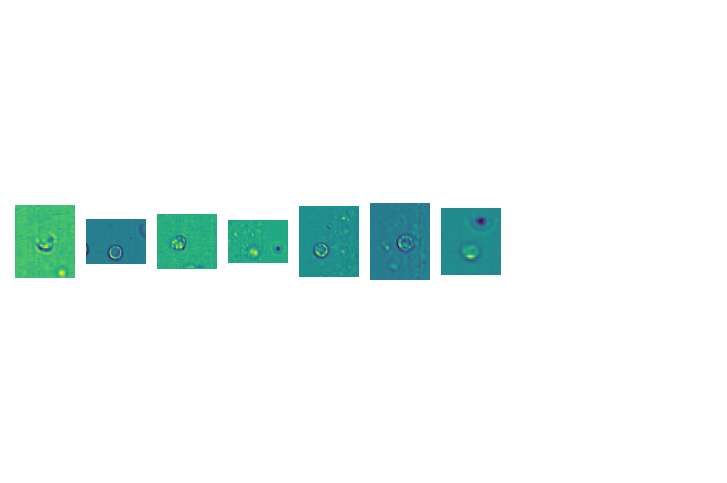

In [49]:
sel = df["meta_regions_BF1"] != 1
plot_gate_zarr(sel, df, maxn=7)

In [50]:
sel = ((df["meta_regions_BF1"] == 1) & (df["meta_regions_BF2"] == 1))

In [51]:
df = df[sel]
df.shape

(116839, 1296)

## NaN values

In [52]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

# Low variance features

In [54]:
v = df.filter(regex="feat").var()

In [55]:
v.isna().sum()

0

In [56]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [57]:
low_var

Index(['feat_euler_number_combined', 'feat_solidity_combined',
       'feat_moments_central-0-1_combined',
       'feat_moments_central-1-0_combined', 'feat_moments_hu-0_combined',
       'feat_moments_hu-1_combined', 'feat_moments_hu-2_combined',
       'feat_moments_hu-3_combined', 'feat_moments_hu-4_combined',
       'feat_moments_hu-5_combined',
       ...
       'feat_glcm_mean_ASM_3_Cy5', 'feat_glcm_mean_ASM_5_Cy5',
       'feat_glcm_std_ASM_3_Cy5', 'feat_glcm_std_ASM_5_Cy5',
       'feat_combined_glcm_std_homogeneity_3_Cy5',
       'feat_combined_glcm_std_homogeneity_5_Cy5',
       'feat_combined_glcm_std_energy_3_Cy5',
       'feat_combined_glcm_std_energy_5_Cy5',
       'feat_combined_glcm_std_ASM_3_Cy5', 'feat_combined_glcm_std_ASM_5_Cy5'],
      dtype='object', length=166)

In [58]:
df = df.drop(columns=low_var)

# Detecting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_BF1', ylabel='feat_minor_axis_length_BF1'>

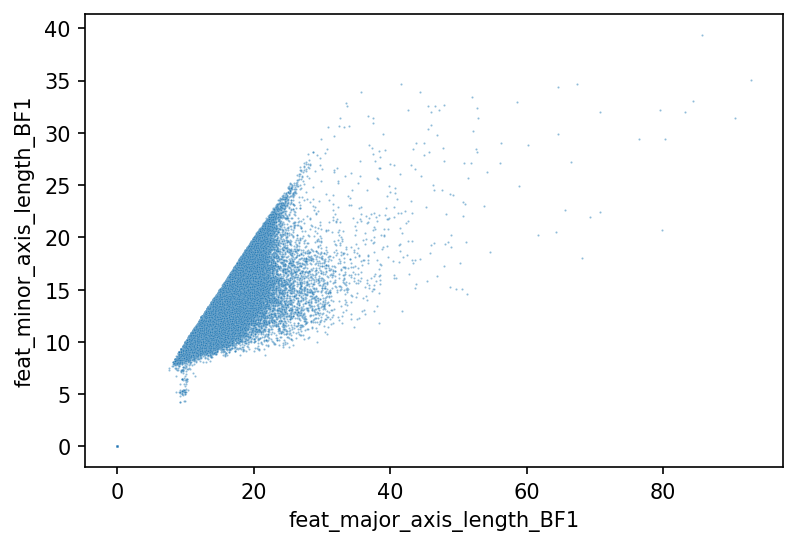

In [59]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5, edgecolors="none")

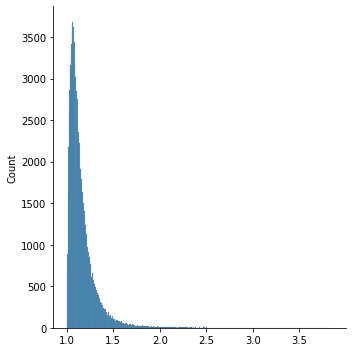

In [60]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(x=feat_majorminor_ratio)

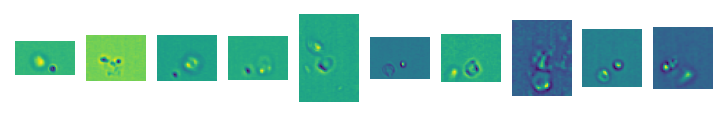

In [61]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df, maxn=10)

In [21]:
df = df[~sel1]
df.shape

(116223, 1130)

<AxesSubplot:xlabel='feat_major_axis_length_TMR', ylabel='Count'>

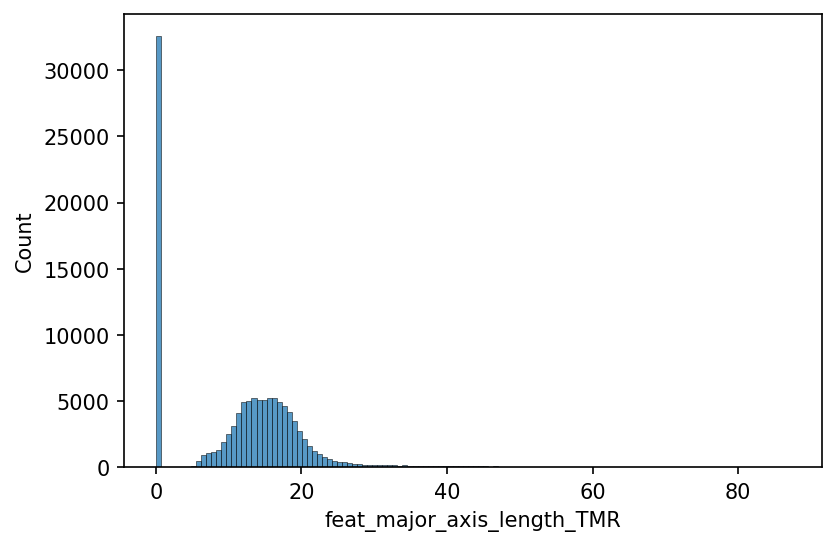

In [62]:
fig, ax = plt.subplots(dpi=150)
seaborn.histplot(ax=ax, data=df, x="feat_major_axis_length_TMR")

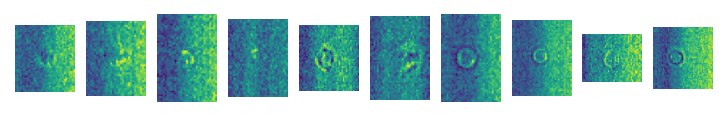

In [63]:
sel1 = df["feat_major_axis_length_TMR"] > 30
plot_gate_zarr(sel1, df, maxn=10, channel=1)

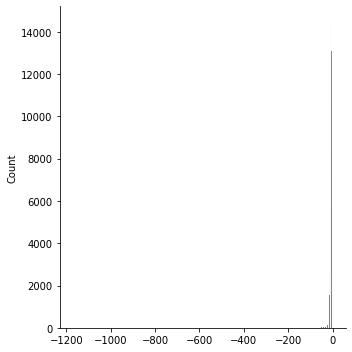

In [64]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

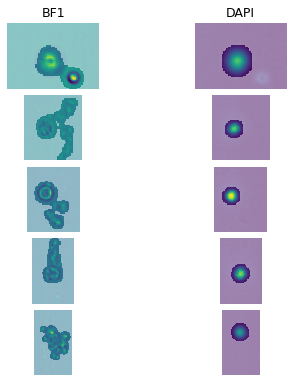

In [65]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -50
core.plot_gate_zarr_channels([sel1], df, maxn=5, main_channel=1, smooth=1, channel_ind=[0, 4], channel_names=["BF1", "DAPI"])

In [66]:
df = df[~sel1]
df.shape

(116197, 1130)

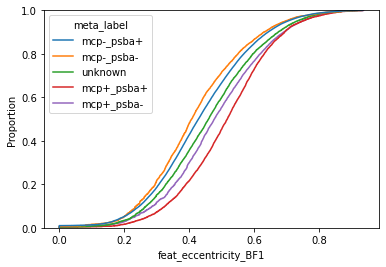

In [67]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_BF1", hue="meta_label")

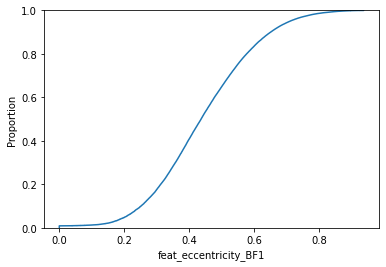

In [68]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_BF1")

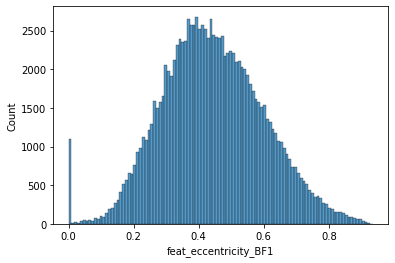

In [69]:
ax = seaborn.histplot(data=df, x="feat_eccentricity_BF1")

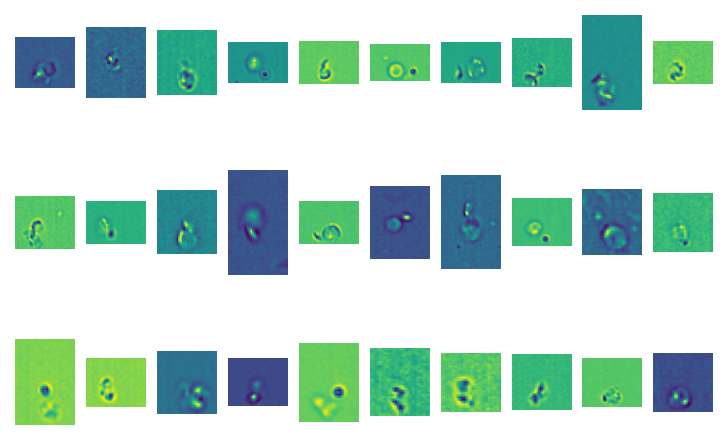

In [70]:
sel1 = df["feat_eccentricity_BF1"] > 0.75
core.plot_gate_zarr(sel1, df, maxn=30)

In [71]:
df = df[~sel1]
df.shape

(112869, 1130)

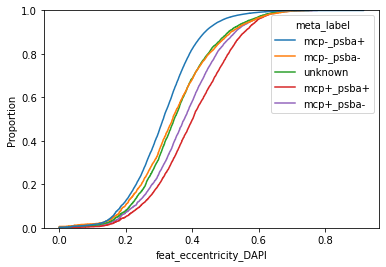

In [72]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_DAPI", hue="meta_label")

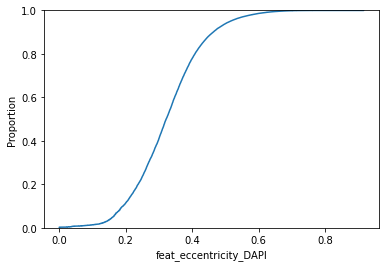

In [73]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_DAPI")

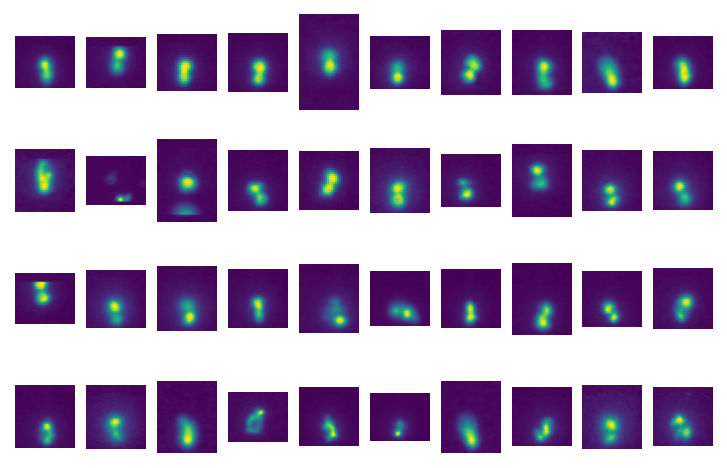

In [74]:
sel1 = df["feat_eccentricity_DAPI"] > 0.7
core.plot_gate_zarr(sel1, df, channel=4, maxn=40)

In [75]:
df = df[~sel1]
df.shape

(112745, 1130)

# Texture features

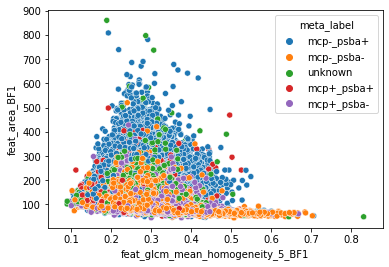

In [66]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_BF1", y="feat_area_BF1", hue="meta_label")

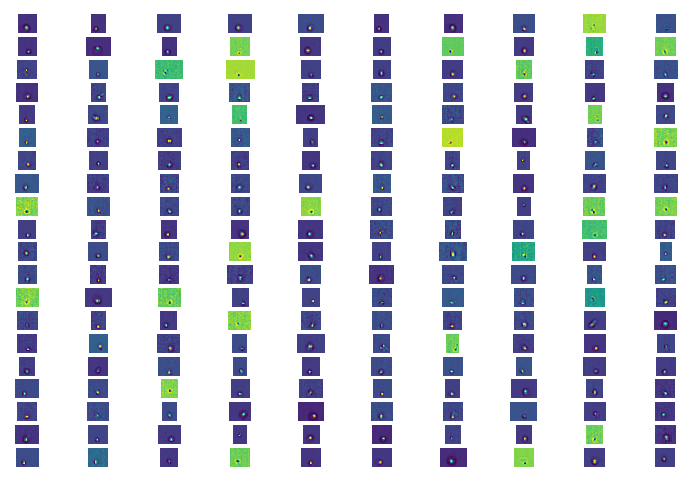

In [53]:
sel1 = df["feat_glcm_mean_homogeneity_5_BF1"] > 0.5
core.plot_gate_zarr(sel1, df)

In [345]:
df[sel1]["meta_label"].value_counts()

mcp-_psba-    168
mcp+_psba-     46
mcp-_psba+     43
unknown        20
mcp+_psba+      1
Name: meta_label, dtype: int64

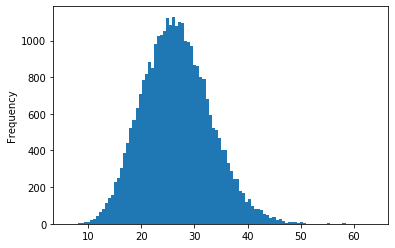

In [54]:
df["feat_glcm_mean_contrast_3_BF1"].plot.hist(bins=100)

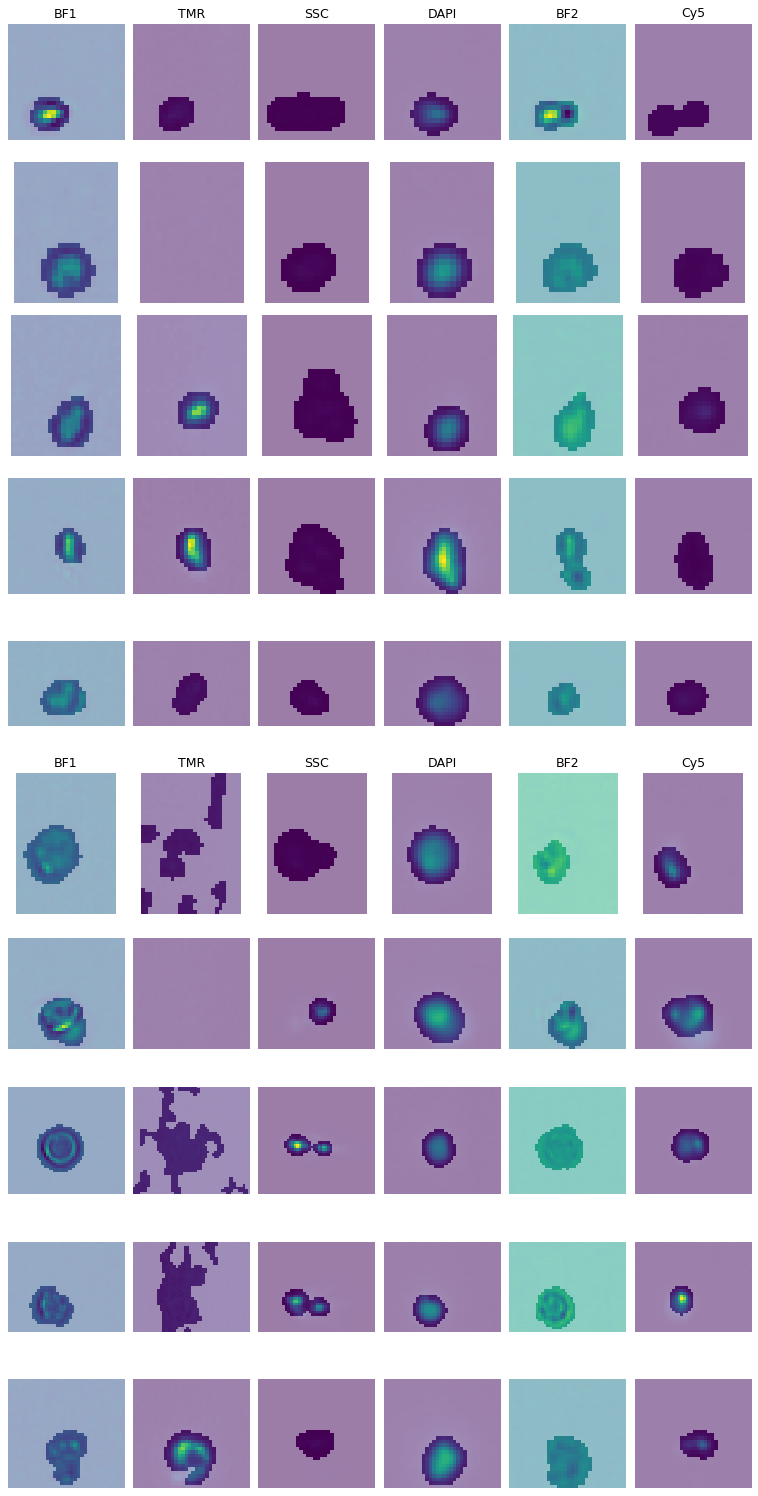

In [347]:
sel1 = df["feat_glcm_mean_contrast_3_BF1"] > 40
sel2 = df["feat_glcm_mean_contrast_3_BF1"] < 10
plot_gate_zarr_channels([sel1, sel2], df, maxn=5, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

# Outlier features or rows

### Normality

In [300]:
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer

In [301]:
for col in df.filter(regex="feat"):
    r = normaltest(df[col])
    if r.pvalue > 0.05:
        print(col)

In [302]:
for col in df.filter(regex="feat"):
    if df[col].min() >= 0:
        r = normaltest(numpy.log(df[col]))
        if r.pvalue > 0.05:
            print(col)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


### Inter-quartile range

In [303]:
cols, amount = [], []
for col in df.drop(columns=df.filter(regex="(TMR|Cy5)$")).filter(regex="feat"):
    q1, q3 = numpy.percentile(df[col], [25, 75])
    cutoff = q3 + (q3-q1)*1.5
    a = (df[col] > cutoff).sum()
    if a > 0:
        cols.append(col)
        amount.append(a)
        
amount = numpy.array(amount)
cols = numpy.array(cols)

In [304]:
len(cols)

557

(array([122.,  76.,  81.,  63.,  69.,  40.,  45.,  48.,  10.,   3.]),
 array([1.00000e+00, 1.46970e+03, 2.93840e+03, 4.40710e+03, 5.87580e+03,
        7.34450e+03, 8.81320e+03, 1.02819e+04, 1.17506e+04, 1.32193e+04,
        1.46880e+04]),
 <a list of 10 Patch objects>)

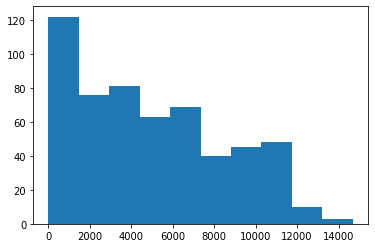

In [305]:
plt.hist(amount)

In [306]:
tmp = cols[numpy.where(amount > 12000)]

In [307]:
tmp[0]

'feat_moments-2-3_combined'

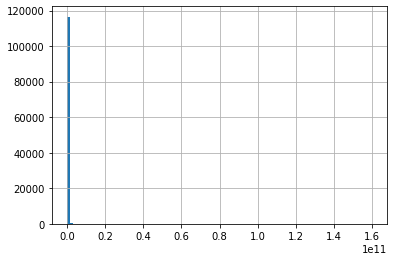

In [308]:
df[tmp[0]].hist(bins=100)

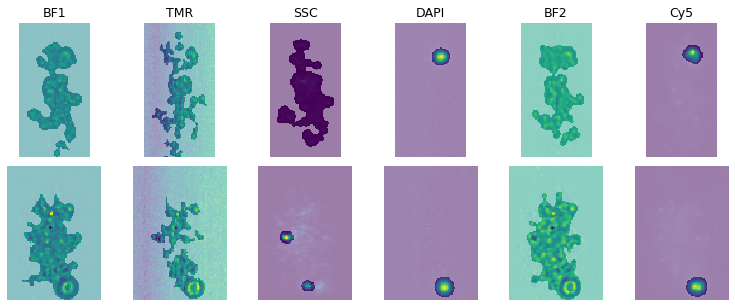

In [309]:
sel1 = df[tmp[0]] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [310]:
tmp[1]

'feat_moments-3-2_combined'

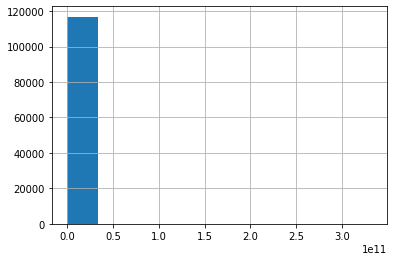

In [311]:
df[tmp[1]].hist()

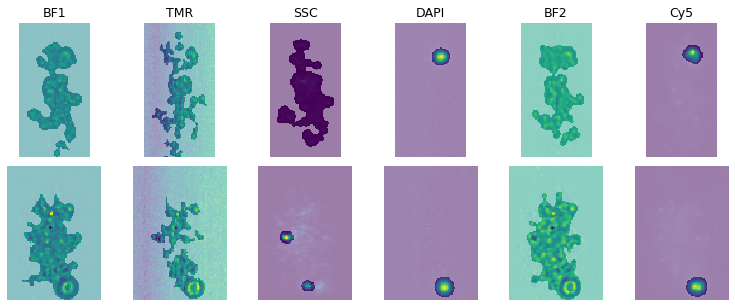

In [312]:
sel1 = df[tmp[1]] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Normalized variance

In [38]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

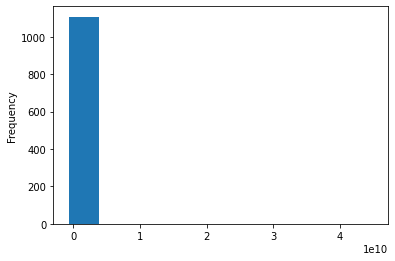

In [39]:
norm_var.plot.hist()

In [40]:
inf_features = norm_var[norm_var.abs() == numpy.inf]

In [41]:
inf_features

Series([], dtype: float64)

In [42]:
for f in inf_features.index:
    s = len(df)
    v = df[f].var()
    while abs(v) == numpy.inf:
        if abs(df[f].min()) > abs(df[f].max()):
            df = df.drop(index=df[f].idxmin())
        else:
            df = df.drop(index=df[f].idxmax())
        v = df[f].var()
    print("Dropped %d rows for %s" % (s-len(df), f))

In [43]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR            2.303946e+10
feat_moments_central-3-3_TMR    4.492679e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

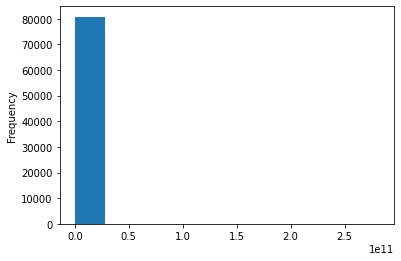

In [44]:
df["feat_moments-3-3_TMR"].plot.hist()

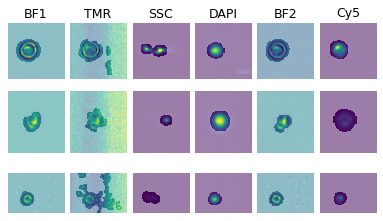

In [45]:
sel1 = df["feat_moments-3-3_TMR"] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [47]:
df = df[~sel1]
df.shape

(112733, 1130)

In [48]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

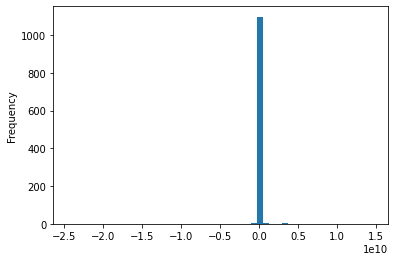

In [49]:
norm_var.plot.hist(bins=50)

In [50]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR    1.459468e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

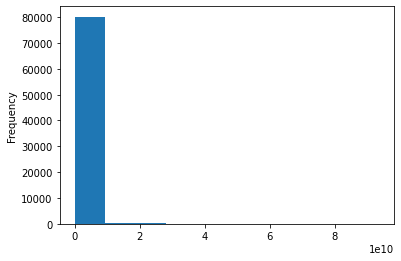

In [51]:
df["feat_moments-3-3_TMR"].plot.hist()

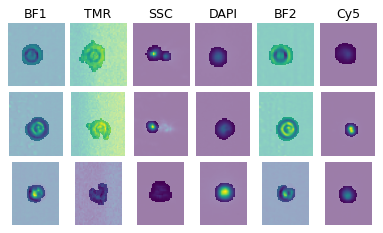

In [52]:
sel1 = df["feat_moments-3-3_TMR"] > 1e10
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [53]:
sel1.sum()

692

In [54]:
df = df[~sel1]
df.shape

(112041, 1130)

In [55]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

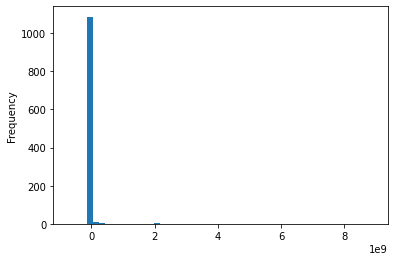

In [56]:
norm_var.plot.hist(bins=50)

In [57]:
norm_var[norm_var > 1e9]

feat_moments-3-3_combined       6.023222e+09
feat_moments-3-3_TMR            2.746597e+09
feat_moments-3-3_SSC            2.098211e+09
feat_moments-3-3_BF2            8.902491e+09
feat_moments_central-3-2_BF2    2.107739e+09
feat_moments-3-3_Cy5            2.554276e+09
dtype: float64

In [58]:
df = df.drop(columns=df.filter(regex="moments-3-3").columns)

In [59]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

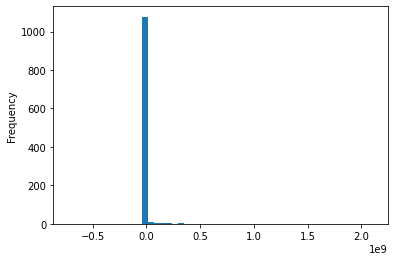

In [60]:
norm_var.plot.hist(bins=50)

In [61]:
norm_var[norm_var > 1e9]

feat_moments_central-3-2_BF2    2.107739e+09
dtype: float64

In [62]:
df = df.drop(columns=df.filter(regex="moments").columns)

In [63]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

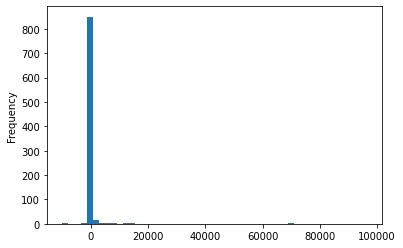

In [64]:
norm_var.plot.hist(bins=50)

In [65]:
norm_var[norm_var > 60000]

feat_sum_SSC                    68923.964801
feat_bgcorr_sum_SSC             78214.991503
feat_combined_sum_SSC           69748.976272
feat_combined_bgcorr_sum_SSC    81171.194601
feat_bgcorr_edge_sum_BF2        96353.681780
dtype: float64

<AxesSubplot:ylabel='Frequency'>

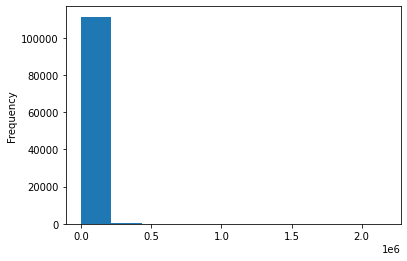

In [66]:
df["feat_sum_SSC"].plot.hist()

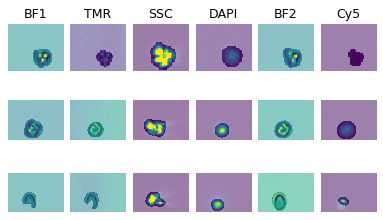

In [106]:
sel1 = df["feat_sum_SSC"] > 400000
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Isolation forest

In [76]:
from sklearn.ensemble import IsolationForest

In [77]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=5, contamination=0.05)
iso.fit(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/data/gent/420/vsc42015/python_lib/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, n_jobs=5, random_state=0)

In [78]:
pred = iso.predict(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

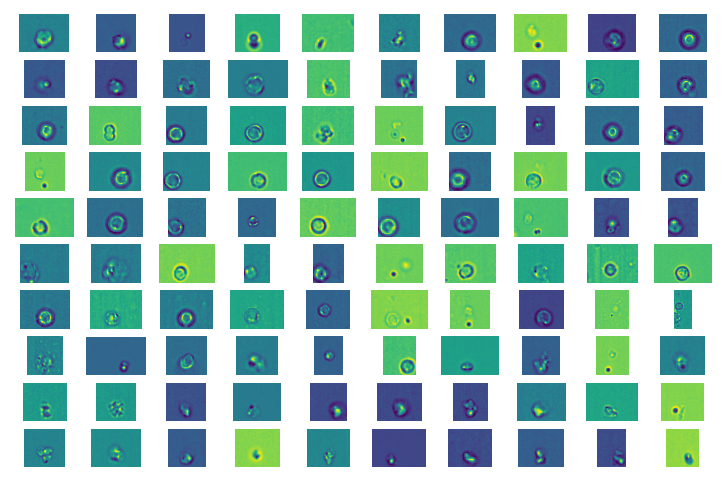

In [100]:
plot_gate_zarr(pred == -1, df, maxn=100)

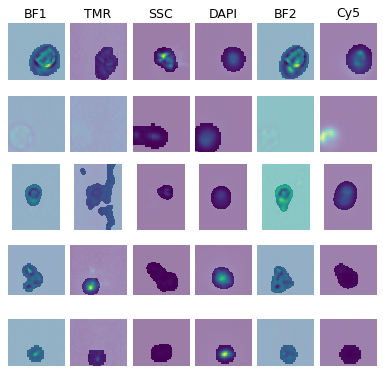

In [132]:
plot_gate_zarr_channels([pred == -1], df, maxn=5, smooth=1, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [71]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  5602, 106439]))

# Feature distributions

In [95]:
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)

In [96]:
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

In [129]:
df = df.loc[numpy.load("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/index.npy", allow_pickle=True)]
df = df[numpy.load("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/columns.npy", allow_pickle=True)]

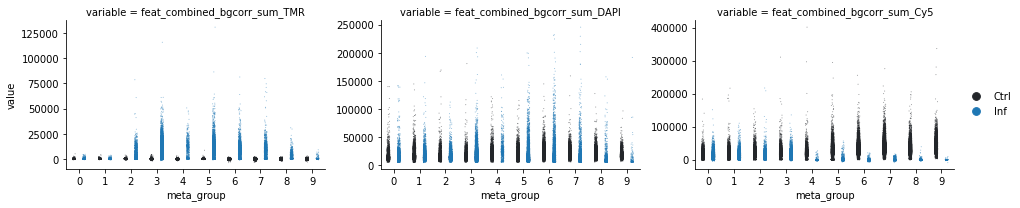

In [97]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_combined_bgcorr_sum_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [116]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[[
        "feat_combined_bgcorr_sum_TMR", 
        "feat_combined_bgcorr_sum_DAPI", 
        "feat_combined_bgcorr_sum_Cy5"
    ]]
    transf = flowutils.transforms.logicle(gdf.values, w=1.3, t=200000, m=4.5, channel_indices=None)
    df.loc[(slice(None), slice(None), slice(None), slice(None), k), [
        "feat_combined_bgcorr_sum_logicle_TMR",
        "feat_combined_bgcorr_sum_logicle_DAPI", 
        "feat_combined_bgcorr_sum_logicle_Cy5"
    ]] = transf

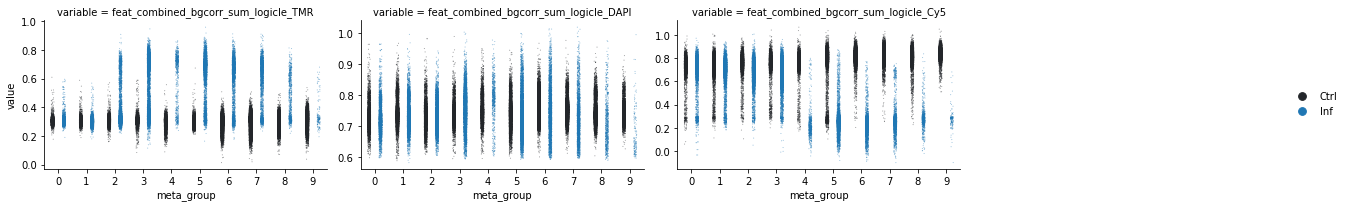

In [117]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_combined_bgcorr_sum_logicle_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [125]:
df[pred == -1].index.get_level_values("meta_type").value_counts()

Ctrl    3668
Inf     1970
Name: meta_type, dtype: int64

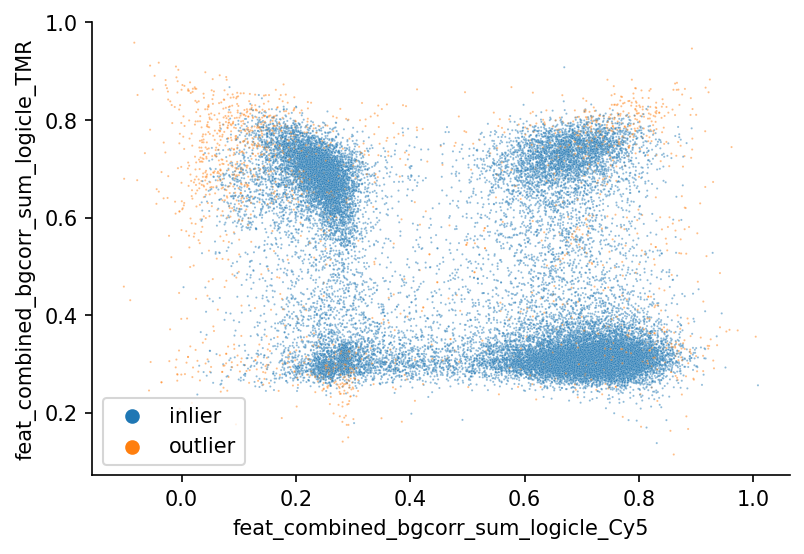

In [128]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    data=df.loc["Inf"], 
    x="feat_combined_bgcorr_sum_logicle_Cy5", 
    y="feat_combined_bgcorr_sum_logicle_TMR", 
    hue=numpy.where(pred[numpy.nonzero(df.index.get_level_values(level="meta_type") == "Inf")] == 1, "inlier", "outlier"), 
    s=1, alpha=0.5, ax=ax
)
seaborn.despine(fig)

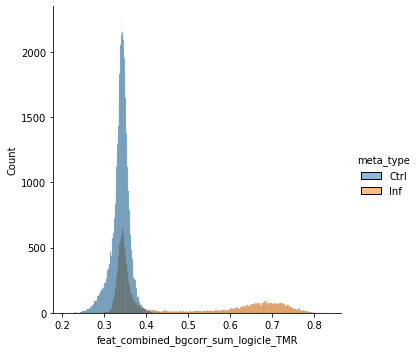

In [89]:
seaborn.displot(data=df, x="feat_combined_bgcorr_sum_logicle_TMR", hue="meta_type")

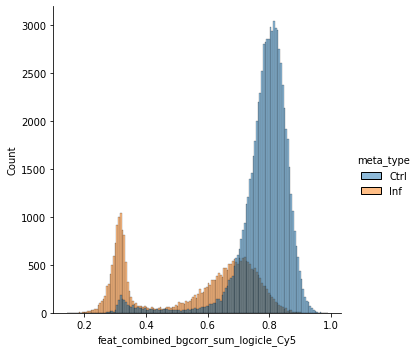

In [90]:
seaborn.displot(data=df, x="feat_combined_bgcorr_sum_logicle_Cy5", hue="meta_type")

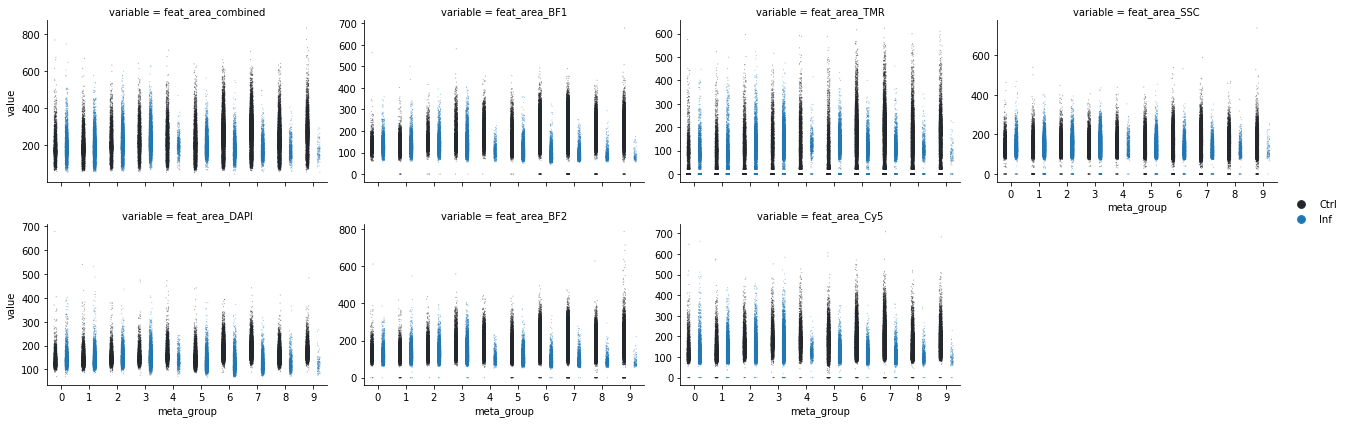

In [18]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="^feat_area_.*").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5, col_wrap=4)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [76]:
df = df[pred == 1]

# Export

In [122]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/index.npy", df.index.values)

In [124]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/columns.npy", df.columns.values)